In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [123]:
cc=pd.read_csv('./credit_card_transaction/cc_info.csv')
trans=pd.read_csv('./credit_card_transaction/transactions.csv')

In [3]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
credit_card          984 non-null int64
city                 984 non-null object
state                984 non-null object
zipcode              984 non-null int64
credit_card_limit    984 non-null int64
dtypes: int64(3), object(2)
memory usage: 38.5+ KB


In [4]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card                  294588 non-null int64
date                         294588 non-null object
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.2+ MB


# Question 1  
Your boss wants to identify those users that in your dataset never went above the monthly credit card limit calendar month. The goal of this is to automatically increase their limit. Can you send him the list of Ids?

In [22]:
# Since all the transactions are from 2015, so we group the data by credit_card and month
trans['month']=pd.DatetimeIndex(trans['date']).month
trans_sum=trans.groupby(['credit_card','month'])['transaction_dollar_amount'].sum().reset_index()

In [27]:
card_spend=trans_sum.pivot(index='credit_card',columns='month',values='transaction_dollar_amount').reset_index()
card_spend=card_spend.merge(cc[['credit_card','credit_card_limit']],on='credit_card',how='left' )

In [31]:
card_spend.head()

,credit_card,7,8,9,10,credit_card_limit
0,1003715054175576,162.56,8441.51,11281.56,8954.21,20000
1,1013870087888817,281.43,11981.15,12461.96,12090.34,15000
2,1023820165155391,943.26,22741.20,18108.12,19259.98,28000
3,1073931538936472,220.07,2991.05,2557.12,1638.03,10000
4,1077622576192810,NaN,634.61,551.28,604.84,10000


In [39]:
month=set(pd.to_datetime(trans.date).dt.month)
for i in range(len(card_spend)):
    n_exceed=0
    for n in month:
        if card_spend.loc[i,n]>card_spend.loc[i,'credit_card_limit']:
            n_exceed+=1
    card_spend.loc[i,'exceed']=n_exceed
    i+=1

In [43]:
card_not_exceed=card_spend[card_spend['exceed']==0]
len(card_not_exceed)

862

So, there are 862 credit cards in total that never exceed their credit limit.

## Question 2
On the other hand, she wants you to implement an algorithm that as soon as a user goes above her monthly limit, it triggers an alert so that the user can be notified about that. We assume here that at the beginning of the new month, user total money spent gets reset to zero (i.e. she pays the card fully at the end of each month). Build a function that for each day, returns a list of users who went above their credit card monthly limit on that day.

In [61]:
def alert(card_info,trans_data,months,days):
    df=pd.merge(left=trans_data, right=card_info, on='credit_card', how='left')
    df['month']=pd.DatetimeIndex(df['date']).month
    df['day']=pd.DatetimeIndex(df['date']).day
    df=df[(df['month']==months) & (df['day']<=days)]
    transaction=df.groupby('credit_card')['transaction_dollar_amount'].sum().reset_index()
    limit=df.groupby('credit_card')['credit_card_limit'].min().reset_index()
    
    merged=transaction.merge(limit,on='credit_card',how='left')
    result=merged[merged['transaction_dollar_amount']>merged['credit_card_limit']].reset_index()
    
    return result

In [62]:
alert(cc,trans,months=8,days=20)

,index,credit_card,transaction_dollar_amount,credit_card_limit
0,194,2850146878241916,4012.81,4000
1,319,3936887050542904,5352.07,4000
2,341,4118286032166087,3416.52,3000
3,383,4462290711836916,3119.53,2000
4,525,5723635641134781,2161.30,2000
5,698,7299183791723634,7074.49,7000
6,772,7850942767136368,5704.00,4000
7,834,8522875529951473,5860.89,5000
8,874,8972201384562696,5266.08,5000


## Question 3
Finally, your boss is very concerned about frauds cause they are a huge cost for credit card companies. She wants you to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further.

I think there are two factors which impact the fraudulance:

1. if the transaction violates the user's habit.

2. if user spend the money far from his home.

In [124]:
# 1.Predict based on user's habit

def statistics_by_card(s):
    ps = [25, 50, 75]
    d = np.percentile(s,ps)
    return pd.Series(d,index=['{}%'.format(p) for p in ps])

tran_statistics = trans.groupby('credit_card')['transaction_dollar_amount'].apply(statistics_by_card).unstack().reset_index()
tran_statistics.head()    

,credit_card,25%,50%,75%
0,1003715054175576,59.01,93.73,124.63
1,1013870087888817,58.09,87.67,128.02
2,1023820165155391,55.43,85.78,122.83
3,1073931538936472,108.08,147.19,194.83
4,1077622576192810,122.93,148.18,160.11


In [125]:
## then merge the 'transaction', 'previous consumption history' and 'credit limit' together, 
## put all useful information about the transaction in one DataFrame
temp = trans.merge(tran_statistics,how='left',on='credit_card')
temp = temp.merge(cc[['credit_card_limit','credit_card']],on='credit_card',how='left')

## we only care about current amount and previous consumption history, so we can keep those useful features
temp=temp[['credit_card','transaction_dollar_amount','25%','50%','75%','credit_card_limit']]
temp.head()

,credit_card,transaction_dollar_amount,25%,50%,75%,credit_card_limit
0,1003715054175576,43.78,59.01,93.73,124.63,20000
1,1003715054175576,103.15,59.01,93.73,124.63,20000
2,1003715054175576,48.55,59.01,93.73,124.63,20000
3,1003715054175576,136.18,59.01,93.73,124.63,20000
4,1003715054175576,71.82,59.01,93.73,124.63,20000


In [127]:
## since credit_limit has much higher variance, I need to scale each feature to unit variance
X=temp[['transaction_dollar_amount','25%','50%','75%','credit_card_limit']]
num_list=['transaction_dollar_amount','25%','50%','75%','credit_card_limit']
for i in num_list:
    X[i] = preprocessing.scale(X[[i]])

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

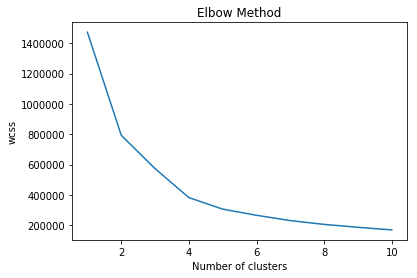

In [128]:
## select clustering method and number of clusters
clusters = range(1,11)
wcss = []

for i in clusters:
    km=KMeans(n_clusters=i)
    km.fit(X)
    wcss.append(km.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

From the WCSS (Within Cluster Sum of Squares), the first 4 clusters have large distances between them and as we move forward, the value gets minimized. So for this data, the optimal number of clusters is set to 4.

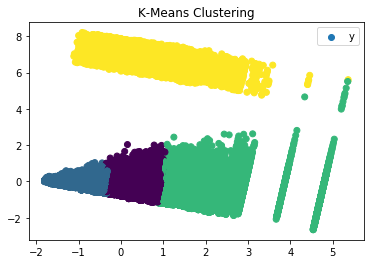

In [133]:
## use Kmeans algorithm to perform the clustering.
km = KMeans(n_clusters=4, max_iter=300, random_state=None)
#X.dropna(axis=0,inplace=True)
km.fit_predict(X)
temp['cluster']=km.predict(X)

# use PCA to reduce dimensions and visualize clusters
pca = PCA(n_components=2, whiten=True)
pca.fit(X)
temp['x'] = pca.fit_transform(X[num_list])[:, 0]
temp['y'] = pca.fit_transform(X[num_list])[:, 1]
plt.scatter(temp['x'],temp['y'],c=temp['cluster'])
plt.title("K-Means Clustering")

plt.show()

In [134]:
print(temp.cluster.value_counts())

0    122452
1    120227
2     46467
3      5442
Name: cluster, dtype: int64


above result also show a good sign, cluster 3 has apparently fewer transcations compared with others. This makes senses, because fraud activity, isn't that normal.

In [137]:
## check the result

suspicious_label = temp.cluster.value_counts().argmin()
suspect = temp.loc[temp.cluster==suspicious_label]
suspect.sample(10)

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  This is separate from the ipykernel package so we can avoid doing imports until


,credit_card,transaction_dollar_amount,25%,50%,75%,credit_card_limit,cluster,x,y
261912,8930627115152996,899.45,33.3450,50.66,70.2725,20000,3,0.378647,6.785987
157624,5684510881502693,875.03,59.9900,93.25,129.1500,12000,3,1.130237,6.410444
89658,3787622376078564,972.53,71.0700,120.45,171.5400,24000,3,2.112797,6.792161
69794,3253141560871065,946.07,36.6725,63.83,95.9175,30000,3,0.968177,6.884199
232415,7898918688943986,823.84,45.9025,75.01,106.3425,20000,3,0.859093,5.979251
66724,3138132199016625,836.01,37.6800,57.52,79.3850,15000,3,0.349685,6.305159
217543,7544799337394642,994.64,30.9000,49.64,69.5450,8000,3,0.093528,7.820817
54032,2639660431498464,993.91,15.8700,24.08,32.9500,9000,3,-0.466717,7.990627
65682,3126713197438541,898.71,62.8900,96.26,133.4300,15000,3,1.313270,6.520691
75533,3384913269838299,881.06,26.9025,44.71,63.4475,5000,3,-0.202451,6.979072


see the randomly sampled suspicious transactions list above, we can find their amount is much higher than that user's 75th percentile in his previous consumption history.

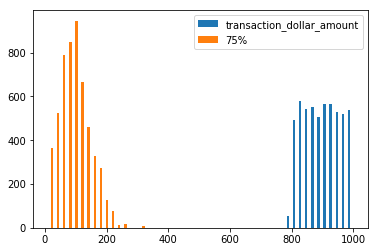

In [139]:
labels = ["transaction_dollar_amount",'75%']
plt.hist(suspect.loc[:,labels].values,bins=50,label=labels)
plt.legend(loc='best')

histogram of the "consumption amount" and that user's 75th percentile of consumption records, also shows, selected transaction has 'amount' much higher than '75th percentile', which is very suspicious and worth further investigation.

In [141]:
# 2.Cluster based on distance

# calculate the median for Longitude and Latitude
data=trans.merge(cc,on='credit_card',how='left')
address = trans.groupby('credit_card')['Long', 'Lat'].median().reset_index()
address = address.rename(columns={'Long': 'Long_median', 'Lat': 'Lat_median'})
data = pd.merge(left=data, right=address, on='credit_card', how='left')

# calculate the distance
data['distance'] = np.sqrt((data['Long'] - data['Long_median'])**2 + (data['Lat'] - data['Lat_median'])**2)

In [144]:
data['month']=pd.DatetimeIndex(data['date']).month
data['day']=pd.DatetimeIndex(data['date']).day
data['weekday']=pd.DatetimeIndex(data['date']).dayofweek
data['hour']=pd.DatetimeIndex(data['date']).hour
data.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,Long_median,Lat_median,distance,month,day,weekday,hour
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000,-80.210281,40.242914,0.043645,9,11,4,0
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000,-80.210281,40.242914,0.064817,10,24,5,22
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000,-80.210281,40.242914,0.070094,10,26,0,18
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000,-80.210281,40.242914,0.060071,10,22,3,19
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000,-80.210281,40.242914,0.081329,10,26,0,20


In [147]:
feature_list=['transaction_dollar_amount','credit_card_limit','weekday', 'hour', 'distance']
X=data[feature_list]
for i in feature_list:
    X[i] = preprocessing.scale(X[[i]])

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.
C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Use

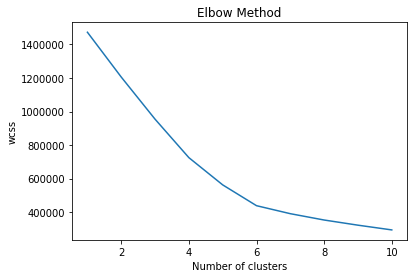

In [148]:
## select clustering method and number of clusters
clusters = range(1,11)
wcss = []

for i in clusters:
    km=KMeans(n_clusters=i)
    km.fit(X)
    wcss.append(km.inertia_)
    
plt.plot(range(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.show()

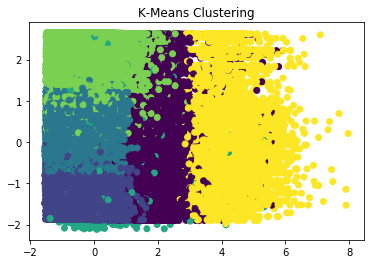

In [150]:
## use Kmeans algorithm to perform the clustering.
km = KMeans(n_clusters=6, max_iter=300, random_state=None)
#X.dropna(axis=0,inplace=True)
km.fit_predict(X)
data['cluster']=km.predict(X)

# use PCA to reduce dimensions and visualize clusters
pca = PCA(n_components=2, whiten=True)
pca.fit(X)
data['x'] = pca.fit_transform(X[feature_list])[:, 0]
data['y'] = pca.fit_transform(X[feature_list])[:, 1]
plt.scatter(data['x'],data['y'],c=data['cluster'])
plt.title("K-Means Clustering")

plt.show()

In [151]:
print(data.cluster.value_counts())

2    136312
1     67316
4     44486
0     37101
5      5421
3      3952
Name: cluster, dtype: int64


In [152]:
## check the result

suspicious_label = data.cluster.value_counts().argmin()
suspect = data.loc[data.cluster==suspicious_label]
suspect.sample(10)

C:\Users\yang\Anaconda2\envs\py3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  This is separate from the ipykernel package so we can avoid doing imports until


,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit,Long_median,Lat_median,distance,month,day,weekday,hour,cluster,x,y
17267,1475826831184689,2015-09-17 18:44:13,72.81,36.358249,59.862678,Charleston,ME,4422,20000,-69.034301,45.062771,106.426626,9,17,3,18,3,0.345130,-0.343219
57828,2817353387367914,2015-10-01 19:45:33,44.47,17.911156,29.327795,New York,NY,10001,15000,-73.992766,40.752305,92.611286,10,1,3,19,3,-0.216467,-0.421344
133322,5000268333411354,2015-09-25 22:11:33,116.30,122.962204,30.587967,Houston,PA,15342,10000,-80.216006,40.234053,203.407059,9,25,4,22,3,-0.195646,-0.424407
94065,3877689042636086,2015-07-31 21:47:14,22.73,114.965622,56.589771,Cascade,MD,21719,10000,-77.481798,39.708615,193.186395,7,31,4,21,3,-0.687141,-0.317741
114918,4339853010378399,2015-10-12 17:06:30,12.68,112.547038,12.492613,Miami,WV,25134,18000,-81.451487,38.154738,195.688457,10,12,0,17,3,-0.100771,-1.493679
145915,5293204730208718,2015-09-17 20:38:56,51.79,3.993828,3.134988,Washington,NH,3280,35000,-72.097342,43.174828,85.982875,9,17,3,20,3,1.449121,-0.524121
100062,4019546939071295,2015-09-26 21:53:37,44.19,26.830138,57.145070,Washington,NH,3280,20000,-72.094854,43.166126,99.907782,9,26,5,21,3,0.200492,0.152298
122247,4672118413151569,2015-08-12 16:01:51,68.54,131.671044,20.426396,Sacramento,PA,17968,14000,-76.611862,40.637864,209.261255,8,12,2,16,3,-0.122335,-0.634843
27975,1800690977956392,2015-09-03 19:37:43,56.73,158.194794,34.579337,Austin,PA,16720,14000,-78.068103,41.610770,236.367505,9,3,3,19,3,-0.167738,-0.559364
164326,5828448317363869,2015-10-21 23:28:59,32.04,148.879665,48.287599,Orlando,WV,26412,7000,-80.569384,38.882541,229.641724,10,21,2,23,3,-0.874174,-1.316340
